In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.distributions.normal as normal
import torchvision
from torchvision import transforms
from torch.utils import data
import torch.utils.data as data_utils
from torch.autograd import Variable
from torch.autograd import grad as torch_grad
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
from sklearn import datasets
from itertools import chain as ichain
import time
from IPython.display import clear_output
import sys

In [2]:
from torchvision.datasets import MNIST
#https://github.com/Manuel4131/GoMNIST/tree/master/data

data_train = MNIST('~/pytorch_data', train=True, download=True,transform = transforms.Compose(
    [transforms.ToTensor()]))

In [3]:
from torch.utils.data import DataLoader
from torchvision import datasets

DATASET_FN_DICT = {'mnist' : datasets.MNIST,
                   'fashion-mnist' : datasets.FashionMNIST
                  }


dataset_list = DATASET_FN_DICT.keys()


def get_dataset(dataset_name='mnist'):
    """
    Convenience function for retrieving
    allowed datasets.
    Parameters
    ----------
    name : {'mnist', 'fashion-mnist'}
          Name of dataset
    Returns
    -------
    fn : function
         PyTorch dataset
    """
    if dataset_name in DATASET_FN_DICT:
        fn = DATASET_FN_DICT[dataset_name]
        return fn
    else:
        raise ValueError('Invalid dataset, {}, entered. Must be '
                         'in {}'.format(dataset_name, DATASET_FN_DICT.keys()))



def get_dataloader(dataset_name='mnist', data_dir='', batch_size=64, train_set=True):

    dset = get_dataset(dataset_name)

    dataloader = torch.utils.data.DataLoader(
        dset(data_dir, train=train_set, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                       ])),
        batch_size=batch_size, shuffle=True)

    return dataloader

In [23]:

def preprocess_img(img):
    """
    Preprocess the images that the are normalized and clipped to a range between -1 and 1
    Input: Batch of images
    Output: Batch of normalized and clipped images
    """
    img = (img.float() / 255- 0.5) * 2
    img = torch.FloatTensor(np.clip(img.numpy(), -1, 1))      
    return img

def deprocess(x):
    """
    Deprocess the normalized vector images back to image format in range 0,255 
    Input: norm image vector with size (1,784)
    Output: image Tensor size (28,28)
    """
    x = (x.detach() / 2 + 1) * 255
    x = torch.clamp(x, min = 0, max = 255)
    return x.view(28,28)

class View(nn.Module):
    def __init__(self, shape):
        super(View, self).__init__()
        self.shape = shape

    def forward(self, x):
        return x.view(x.size(0),*self.shape)

def calc_gradient_penalty(netD, real_data, generated_data):
    """
    
    """
    # GP strength
    LAMBDA = 10

    b_size = real_data.size()[0]
    # Calculate interpolation
    alpha = torch.rand(b_size,1, 1, 1)
    alpha = alpha.expand_as(real_data).to(device)
    if b_size == 32:
        generated_data = generated_data[:32]
    #assert real_data.shape == (64,1,28,28), "real_data is not in 64,1,28,28 shape but rather {} - alpha: {}".format(real_data.shape, alpha.shape)
    #assert alpha.shape == (64,1,28,28), "alpha is not in 64,1,28,28 shape  but rather {} ".format(alpha.shape)
    interpolated = alpha * real_data.data + (1 - alpha) * generated_data.data
    interpolated = interpolated.requires_grad_(True)

    # Calculate probability of interpolated examples
    prob_interpolated = netD(interpolated)

    # Calculate gradients of probabilities with respect to examples
    gradients = torch_grad(outputs=prob_interpolated, inputs=interpolated,
                           grad_outputs=torch.ones(prob_interpolated.size()).to(device),
                           create_graph=True, retain_graph=True)[0]

    # Gradients have shape (batch_size, num_channels, img_width, img_height),
    # so flatten to easily take norm per example in batch
    gradients = gradients.view(b_size, -1)

    # Derivatives of the gradient close to 0 can cause problems because of
    # the square root, so manually calculate norm and add epsilon
    gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1) + 1e-12)

    # Return gradient penalty
    return  LAMBDA * ((gradients_norm - 1.0) ** 2).mean()

def plot(frame_idx, z_error, X_error):
    """
    Plots: || z - E(G(z))||
    and    || X - G(E(X))||
    """
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title("Cycle L2-distance loss")
    plt.plot(z_error, label = "|| z - E(G(z))||", color = "r")
    plt.plot(X_error, label = "|| X - G(E(X))||", color = "b")
    plt.ylabel = "L2-loss"
    plt.legend(loc='upper right')
    plt.show()
def sample_z(shape=64, latent_dim=10, n_c=10, fix_class=-1, req_grad=False):

    assert (fix_class == -1 or (fix_class >= 0 and fix_class < n_c) ), "Requested class %i outside bounds."%fix_class

    Tensor = torch.FloatTensor
    
    # Sample noise as generator input, zn
    zn = Variable(Tensor(0.75*np.random.normal(0, 1, (shape, latent_dim))), requires_grad=req_grad)

    ######### zc, zc_idx variables with grads, and zc to one-hot vector
    # Pure one-hot vector generation
    zc_FT = Tensor(shape, n_c).fill_(0)
    zc_idx = torch.empty(shape, dtype=torch.long)

    if (fix_class == -1):
        zc_idx = zc_idx.random_(n_c)#.cuda()
        zc_FT = zc_FT.scatter_(1, zc_idx.unsqueeze(1), 1.)
    else:
        zc_idx[:] = fix_class
        zc_FT[:, fix_class] = 1

        zc_idx = zc_idx.cuda()
        zc_FT = zc_FT.cuda()

    zc = Variable(zc_FT, requires_grad=req_grad)

    # Return components of latent space variable
    return zn, zc, zc_idx

In [8]:
import torch.utils.data as data_utils
train_data = datasets.MNIST(root = './data', train = True,
                        transform = transforms.ToTensor(), download = True)
data_loader = torch.utils.data.DataLoader(train_data,
                                          batch_size=64,
                                          shuffle=True)


# Weight Initializer
def initialize_weights(net):
    for m in net.modules():
        if isinstance(m, nn.Conv2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, nn.ConvTranspose2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, nn.Linear):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()

class Generator(nn.Module):
    def __init__(self, latent_dim, nr_classes,img_shape = (1,28,28)):
        super(Generator, self).__init__()
        self.img_shape = img_shape
        self.ishape = (128,7,7)
        self.dim = int(np.prod(self.ishape))
        self.network = nn.Sequential(nn.Linear(latent_dim + nr_classes, 1024),
                                    nn.LeakyReLU(0.2, inplace = True),
                                    nn.BatchNorm1d(1024),
                                    nn.Linear(1024, self.dim),
                                    nn.LeakyReLU(0.2, inplace = True),
                                    nn.BatchNorm1d(self.dim),
                                    View(self.ishape), #Reshape
                                    nn.ConvTranspose2d(in_channels = 128, out_channels = 64, kernel_size = 4, stride=2, padding=1),
                                    nn.LeakyReLU(0.2, inplace = True),
                                    nn.BatchNorm2d(64),
                                    nn.ConvTranspose2d(in_channels = 64, out_channels = 1, kernel_size = 4, stride=2, padding=1),
                                    nn.Sigmoid())
        initialize_weights(self)
                                    
    def forward(self, zn, zc):
        x = torch.cat((zn,zc), dim = 1)
        x = self.network(x)
        # reshape
        x = x.view(x.size(0), *self.img_shape)
        return x

    
class Encoder(nn.Module):
    def __init__(self, latent_dim, nr_classes):
        super(Encoder, self).__init__()
        # bekommt 28x28 input image
        self.latent_dim = latent_dim
        self.logits_out = int(np.prod((128,5,5)))
        self.logits_conv_shape = (self.logits_out,)
        self.encoder = nn.Sequential(nn.Conv2d(in_channels = 1, out_channels = 64, kernel_size = 4, stride = 2 ),
                                    nn.LeakyReLU(0.2,inplace = True),
                                    nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size= 4, stride = 2),
                                    nn.LeakyReLU(0.2,inplace = True),
                                    View(self.logits_conv_shape),
                                    nn.Linear(self.logits_out,1024),
                                    nn.LeakyReLU(0.2,inplace = True),
                                    nn.Linear(1024,self.latent_dim + nr_classes))
        initialize_weights(self)
        
    def forward(self, x):
        z_img = self.encoder(x)
        z = z_img.view(z_img.shape[0],-1)
        # Seperating continous and one-hot vectors
        zn = z[:, :self.latent_dim]
        zc_logits = z[:, self.latent_dim:]
        # Softmax on last 10 (nr classes) to obtain zc
        zc = torch.softmax(zc_logits, dim = 1)
        return zn, zc, zc_logits
        
        
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.logits_out = int(np.prod((128,5,5)))
        self.logits_conv_shape = (self.logits_out,)
        self.network = nn.Sequential(nn.Conv2d(in_channels = 1, out_channels = 64, kernel_size = 4, stride = 2 ),
                                    nn.LeakyReLU(0.2,inplace = True),
                                    nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 4, stride = 2),
                                    nn.LeakyReLU(0.2,inplace = True),
                                     
                                    View(self.logits_conv_shape),                                    
                                    
                                    nn.Linear(self.logits_out,1024),
                                    nn.LeakyReLU(0.2,inplace = True),
                                    nn.Linear(1024,1))
        initialize_weights(self)
    def forward(self, x):
        return self.network(x)

Processing...
Done!


In [38]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
latent_space_zn = 30 # latentspace
nr_c = 10 # nr of classes
BATCH_SIZE = 64
generator = Generator(latent_space_zn, nr_c).to(device)
encoder = Encoder(latent_space_zn, nr_c).to(device)
discriminator = Discriminator().to(device)

beta1 = 0.5
beta2 = 0.9
lr = 1e-4
decay = 2.5*1e-5

generator_param_chain = ichain(generator.parameters(),
                      encoder.parameters())
optimizer_G = optim.Adam(generator_param_chain,lr = lr, betas = (beta1, beta2), weight_decay = decay)
optimizer_D = optim.Adam(discriminator.parameters(), lr = lr, betas = (beta1, beta2))

cross_entropy_loss = torch.nn.CrossEntropyLoss()
mse_loss = torch.nn.MSELoss()

print(generator)
print("\n", encoder)
print("\n", discriminator)

Generator(
  (network): Sequential(
    (0): Linear(in_features=40, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=1024, out_features=6272, bias=True)
    (4): LeakyReLU(negative_slope=0.2, inplace)
    (5): BatchNorm1d(6272, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): View()
    (7): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (8): LeakyReLU(negative_slope=0.2, inplace)
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (11): Sigmoid()
  )
)

 Encoder(
  (encoder): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2))
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2))
    (3): L

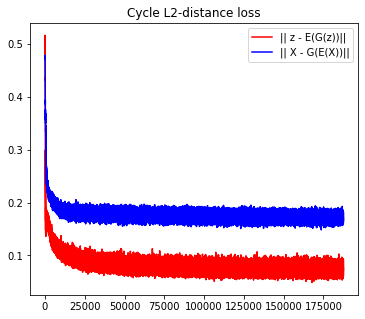

In [39]:
start_time = time.time()

step = 0
epochs = 200
overall_loss_d = []
overall_loss_g = []

l2_x = []
l2_z = []

saved_generator_imgs = [] #saves one image each episode
generator_predictions = [] # saves the predictions of the discriminator to the fake images
for epoch in range(epochs):
    episodic_loss_d = []
    episodic_loss_g = []

    for idx, batch in enumerate(data_loader):
        
        generator.train()
        encoder.train()
        generator.zero_grad()
        encoder.zero_grad()
        discriminator.zero_grad()
        optimizer_G.zero_grad()
        x, y = batch 
        #zn, zc, zc_idx = generator_input_sampler(latent_space_zn, batch_size=32) # create fake digits
        zn, zc, zc_idx = sample_z(latent_dim=latent_space_zn, shape=BATCH_SIZE)

        x_fake = generator(zn.to(device),zc.to(device)) # create fake imgs
        pred_real = discriminator(x.to(device))
        pred_fake = discriminator(x_fake)
        
        enc_gen_zn, enc_gen_zc, enc_gen_zc_logits = encoder(x_fake)
        
        #Train Generator
        # calc losses:        
        zn_loss = mse_loss(enc_gen_zn, zn.to(device))
        zc_loss = cross_entropy_loss(enc_gen_zc_logits, zc_idx.to(device))        

        # generator loss
        beta_n = 10
        beta_c = 10
        g_loss = torch.mean(pred_fake) + beta_n * zn_loss + beta_c * zc_loss   # value 10 depents on nr of classes
        g_loss.backward(retain_graph=True)
        optimizer_G.step()
        episodic_loss_g.append(g_loss.item())         
        
        
        #Train Discriminator
        optimizer_D.zero_grad()
        grad_penalty = calc_gradient_penalty(discriminator, x.to(device), x_fake)
        loss_d = torch.mean(pred_real) - torch.mean(pred_fake) + grad_penalty
        loss_d.backward()
        optimizer_D.step()
        episodic_loss_d.append(loss_d.item())
        
        generator.eval()
        encoder.eval()
        
        if idx == 0:
            # Saves the first produced image each episode
            random_nr = np.random.random_integers(0,BATCH_SIZE-1)
            saved_generator_imgs.append(deprocess(x_fake[random_nr]))
            generator_predictions.append(pred_fake[random_nr])
    
        step += 1
        
        #### Calc L2-distance loss
        ### || z - E(G(z)) || and || X - G(E(X))||
        z = torch.cat((zn,zc), dim = 1)
        E_G_z = torch.cat((enc_gen_zn, enc_gen_zc), dim = 1)
        z_error = abs(z.detach().cpu().numpy() - E_G_z.detach().cpu().numpy()).mean()
        l2_z.append(z_error)
        
        X_zn, X_zc, X_id = encoder(x.to(device))
        G_E_X = generator(X_zn, X_zc).squeeze(1)
        X_error = np.sqrt((x.numpy()-G_E_X.detach().cpu().numpy())**2).mean()     
        l2_x.append(X_error)
        
        if epoch == 0 and idx ==0:
            overall_loss_g.append(np.array(episodic_loss_g).mean())
            overall_loss_d.append(np.array(episodic_loss_d).mean())
        ##### Monitoring:
        
        print("\rDiscriminator loss: {} || Batch Generator loss {}".format(round(loss_d.detach().cpu().numpy().mean(),2), round(g_loss.detach().cpu().numpy().mean(),2)), end = "")
        sys.stdout.flush()
        
              
    overall_loss_g.append(np.array(episodic_loss_g).mean())
    overall_loss_d.append(np.array(episodic_loss_d).mean())
    print("\nEpisode: {} -- Discriminator loss: {} -- Generator loss: {}".format(epoch, np.array(episodic_loss_d).mean(), np.array(episodic_loss_g).mean()))
    
    plot(epoch, l2_z, l2_x)

end_time = time.time()

Training took 163.1923653880755 min


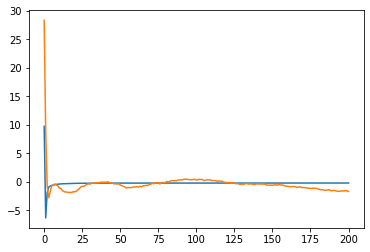

In [40]:
print("Training took {} min".format((end_time-start_time)/60))
plt.plot(overall_loss_d)
plt.plot(overall_loss_g)
plt.show()

In [41]:
from sklearn.manifold import TSNE
import matplotlib
import matplotlib.cm as cm
tsne = TSNE(n_components=2, verbose=1, init='pca', random_state=42)

In [42]:
imgs_ = []
labels_ = []
for i in range(100):
    imgs, labels = next(iter(data_loader))
    imgs_.append(imgs)
    labels_.append(labels)
imgs = torch.cat(imgs_, dim = 0)
labels = torch.cat(labels_, dim = 0)

enc_zn, enc_zc, enc_zc_logits = encoder(imgs.to(device))
enc = np.hstack((enc_zn.cpu().detach().numpy(), enc_zc_logits.cpu().detach().numpy()))
tsne_enc = tsne.fit_transform(enc)
labels = labels.data.numpy()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 6400 samples in 0.006s...
[t-SNE] Computed neighbors for 6400 samples in 1.155s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6400
[t-SNE] Computed conditional probabilities for sample 2000 / 6400
[t-SNE] Computed conditional probabilities for sample 3000 / 6400
[t-SNE] Computed conditional probabilities for sample 4000 / 6400
[t-SNE] Computed conditional probabilities for sample 5000 / 6400
[t-SNE] Computed conditional probabilities for sample 6000 / 6400
[t-SNE] Computed conditional probabilities for sample 6400 / 6400
[t-SNE] Mean sigma: 1.384785
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.620041
[t-SNE] Error after 1000 iterations: 1.239926


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

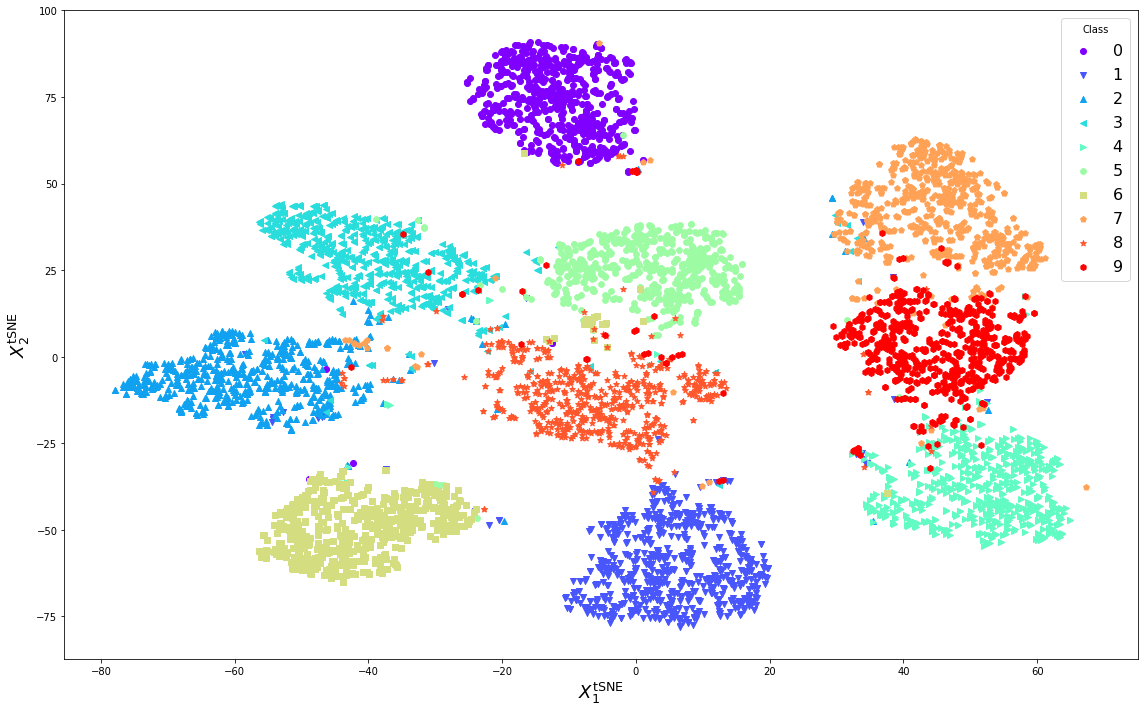

In [43]:
colors = cm.rainbow(np.linspace(0, 1, nr_c))
markers = matplotlib.markers.MarkerStyle.filled_markers

    # Save TSNE figure to file
fig, ax = plt.subplots(figsize=(16,10))
for iclass in range(0, nr_c):
        # Get indices for each class
    idxs = labels==iclass
        # Scatter those points in tsne dims
    ax.scatter(tsne_enc[idxs, 0],
                tsne_enc[idxs, 1],
                marker=markers[iclass],
                c=colors[iclass],
                edgecolor=None,
                label=r'$%i$'%iclass)

    #ax.set_title(r'%s'%fig_title, fontsize=24)
    ax.set_xlabel(r'$X^{\mathrm{tSNE}}_1$', fontsize=18)
    ax.set_ylabel(r'$X^{\mathrm{tSNE}}_2$', fontsize=18)
    plt.legend(title=r'Class', loc='best', numpoints=1, fontsize=16)
    plt.tight_layout()
    fig.savefig('tsne-pca.png')